In [1]:
import os
import requests
import pandas as pd
import numpy as np
import healpy as hp
import subprocess as sp
import ligo.skymap.plot
import matplotlib.pyplot as plt
from datetime import datetime
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy import units as u
from scipy.optimize import curve_fit
from tiling import get_time_radius
from ligo.skymap.io import read_sky_map, fits
import matplotlib
params={
    'text.usetex':True,
    'font.family':'serif',
    'xtick.minor.visible':True,
    'ytick.minor.visible':True,
    'xtick.top':True,
    'ytick.left':True,
    'ytick.right':True,
    'xtick.direction':'out',
    'ytick.direction':'out',
    'xtick.minor.size':2.5,
    'xtick.major.size':5,
    'ytick.minor.size':2.5,
    'ytick.major.size':5,
    'axes.axisbelow':True
}
matplotlib.rcParams.update(params)

In [2]:
coverage = pd.DataFrame(pd.read_csv("/home/ravioli/astro/git/fermi_grbs/coverage_2h.csv"))
total_maps_tiled = len(coverage['coverage'].values[np.where(np.logical_and(coverage['coverage'].values!='None', coverage['coverage'].values!='DID NOT RISE'))])
print("Total number of probability maps tiled: ", total_maps_tiled)
print(f"Total time taken:  16000 seconds ~ {np.round(16000/total_maps_tiled, 2)} seconds per map")

Total number of probability maps tiled:  996
Total time taken:  16000 seconds ~ 16.06 seconds per map


In [3]:
PIX_AREA = hp.nside2pixarea(128, degrees=True)
def get_loc_size(healpix, frac=0.9):
    hpmap = read_sky_map(healpix)[0]
    sortorder = np.argsort(hpmap)[::-1]
    n_pix = len(sortorder[:np.where(np.cumsum(hpmap[sortorder])/np.sum(hpmap)>frac)[0][0]])
    return n_pix*PIX_AREA

In [4]:
radius = coverage['radius'].values
probs = coverage['coverage'].values
healpix = coverage['healpix'].values
radius = radius[np.where(np.logical_and(np.logical_and(probs!='NOT VISIBLE',probs!='None'), probs!="DID NOT RISE"))].astype(float)
healpix = healpix[np.where(np.logical_and(np.logical_and(probs!='NOT VISIBLE',probs!='None'), probs!="DID NOT RISE"))]
probs = probs[np.where(np.logical_and(np.logical_and(probs!='NOT VISIBLE',probs!='None'), probs!="DID NOT RISE"))].astype(float)
probs = probs[radius<30]
healpix = healpix[radius<30]
radius = radius[radius<30]
probs = probs[np.argsort(radius)]
healpix = healpix[np.argsort(radius)]
radius = radius[np.argsort(radius)]
area = []
times = []
for heal in healpix:
    file = "/home/ravioli/astro/git/fermi_grbs/data/"+heal
    covragefile = "/home/ravioli/astro/git/fermi_grbs/data/"+heal+"_scheduled_2h.csv"
    times.append(len(pd.DataFrame(pd.read_csv(covragefile)))*5)
    area.append(get_loc_size(file, frac=0.5))
area = np.array(area)
times = np.array(times)

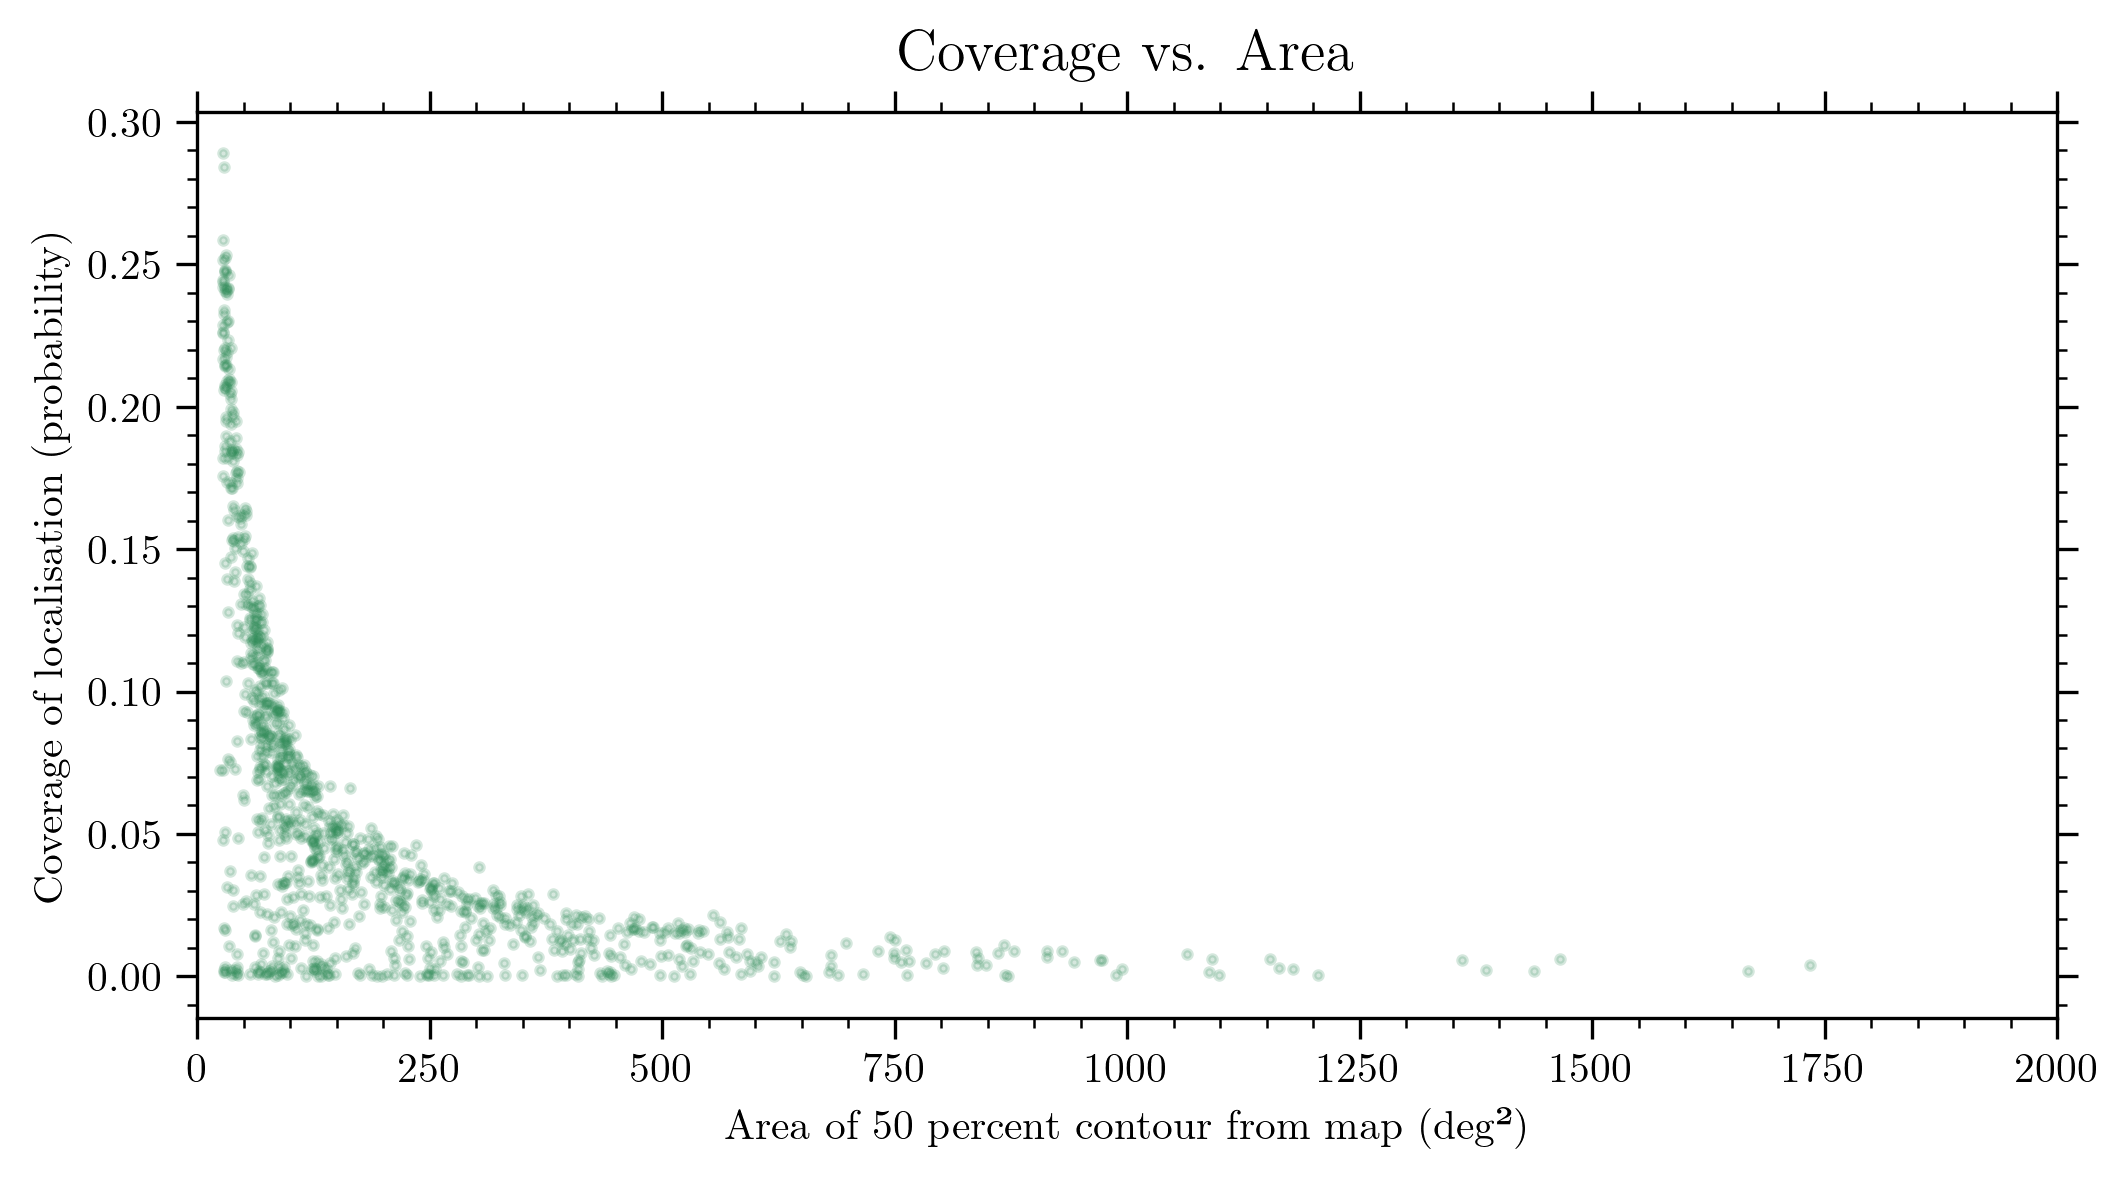

In [5]:
plt.figure(figsize=(8,4), dpi=300)
plt.scatter(area, probs, s=4, color='seagreen', alpha=0.2)
plt.xlabel("Area of 50 percent contour from map (deg²)")
plt.ylabel("Coverage of localisation (probability)")
plt.title("Coverage vs. Area", fontsize=14, pad=10)
plt.xlim(0,1000)
plt.show()

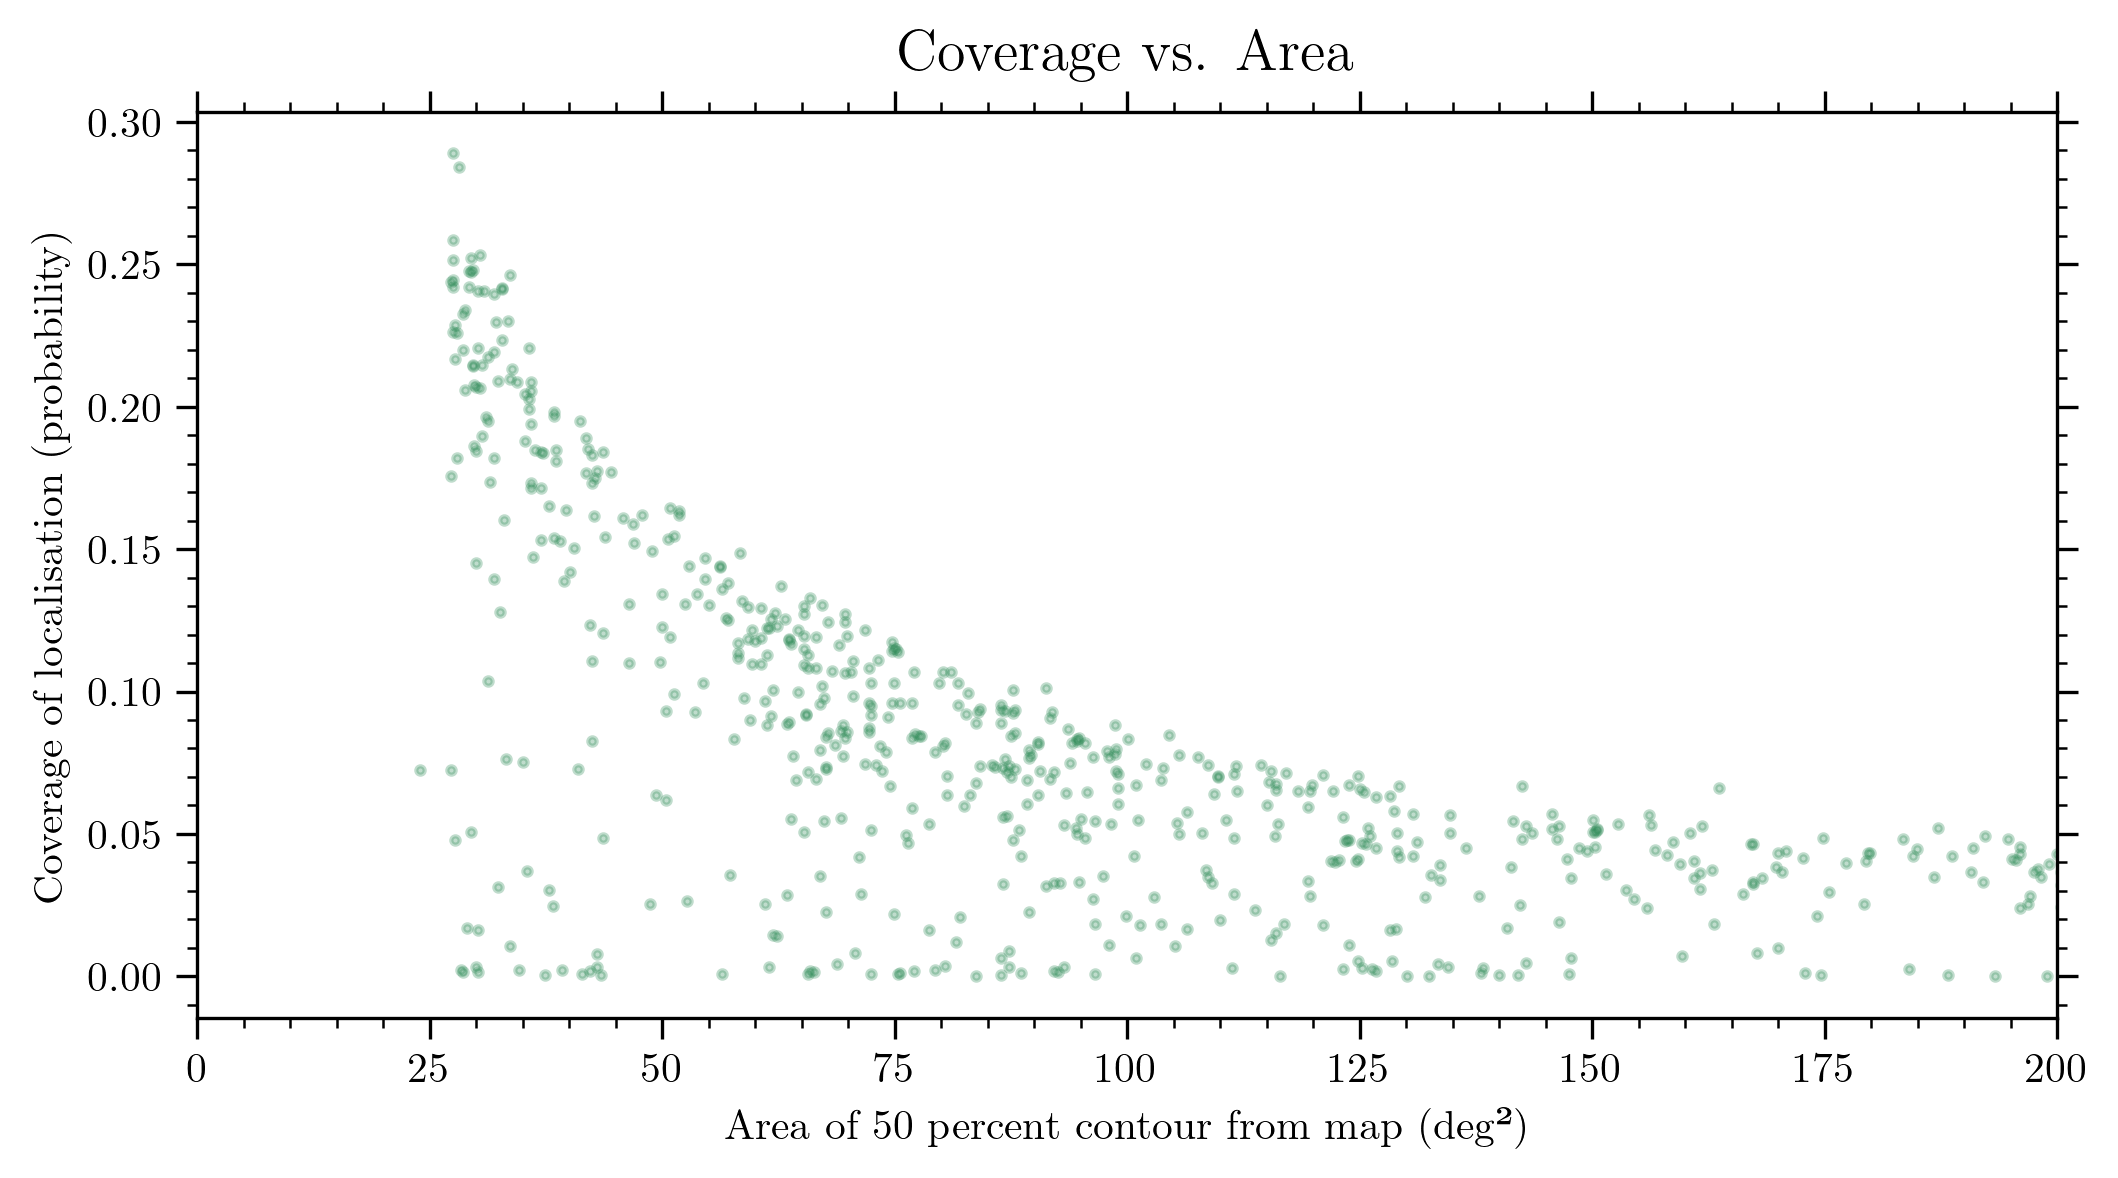

In [6]:
plt.figure(figsize=(8,4), dpi=300)
plt.scatter(area, probs, s=4, color='seagreen', alpha=0.3)
plt.xlabel("Area of 50 percent contour from map (deg²)")
plt.ylabel("Coverage of localisation (probability)")
plt.title("Coverage vs. Area", fontsize=14, pad=10)
plt.xlim(0,200)
plt.show()

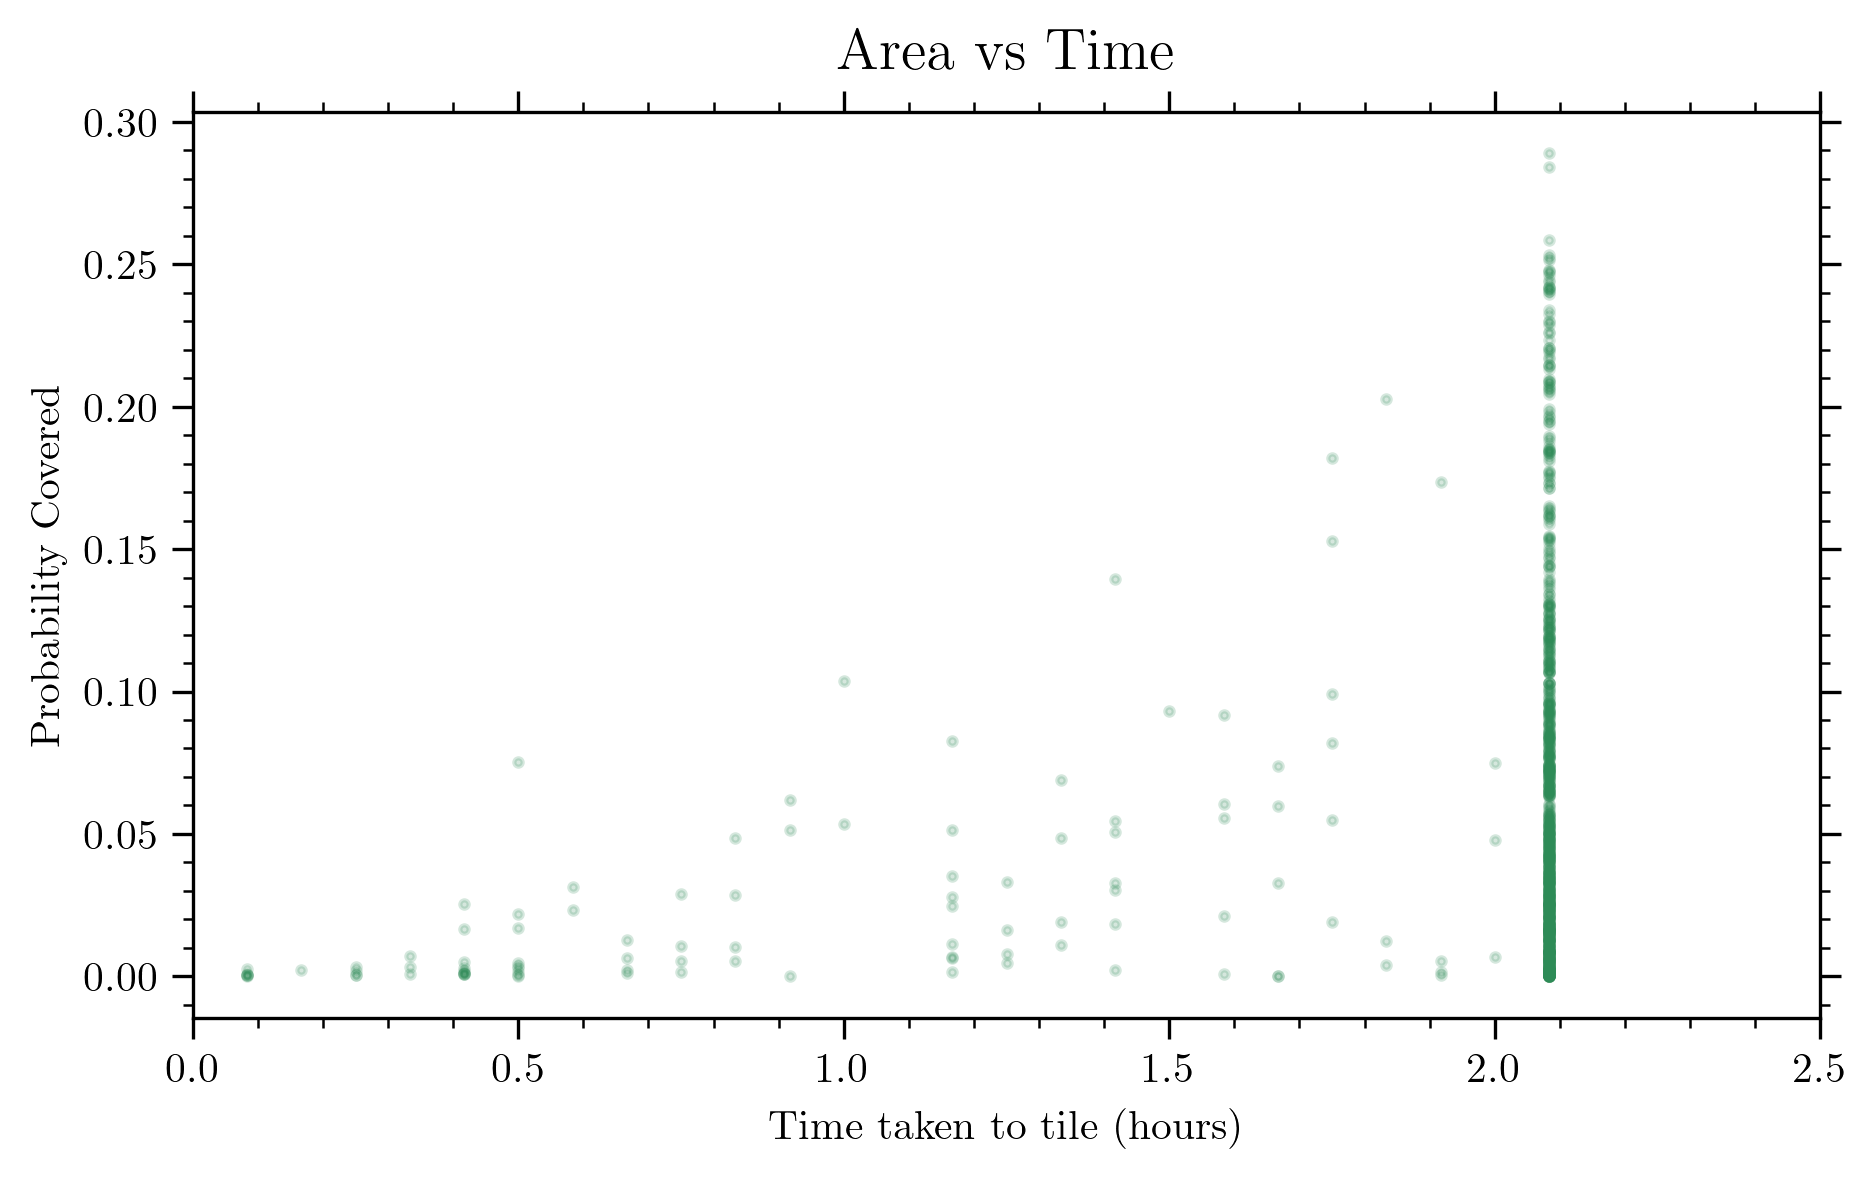

In [7]:
plt.figure(figsize=(7,4), dpi=300)
plt.scatter(times/60, probs, s=4, color='seagreen', alpha=0.2)
plt.xlabel("Time taken to tile (hours)")
plt.ylabel("Probability Covered")
plt.title("Area vs Time", fontsize=14, pad=10)
# plt.ylim(0,200)
plt.xlim(0,2.5)
plt.show()

In [12]:
for pcut in [0.05, 0.1, 0.15, 0.2]:
    select = probs > pcut
    n_obs = np.sum(select)
    tobs = np.sum(times[select]) / 60
    tot_prob = np.sum(probs[select])
    print(f"{n_obs} GRBs with prob > {pcut:0.2f}, total probab = {tot_prob:0.1f}, tot time = {tobs}h, time/grb = {tobs/tot_prob:0.2f} ")

398 GRBs with prob > 0.05, total probab = 46.1, tot time = 813.4166666666666h, time/grb = 17.63 
192 GRBs with prob > 0.10, total probab = 31.1, tot time = 397.1666666666667h, time/grb = 12.75 
98 GRBs with prob > 0.15, total probab = 19.8, tot time = 203.08333333333334h, time/grb = 10.27 
48 GRBs with prob > 0.20, total probab = 11.0, tot time = 99.75h, time/grb = 9.04 
